# Домашнее задание 
### Feature Engineering & Feature Selection

**Цель**: Повторить вычисления из лекции на данном датасете: https://archive.ics.uci.edu/ml/datasets/IDA2016Challenge

Задача данного ДЗ - опробовать методы преобразования признаков на датасете: https://archive.ics.uci.edu/ml/datasets/IDA2016Challenge

Ваша цель получить как можно более высокие метрики сконцентрировавшись на преобразовании признаков.
Опробуйте различные техники - замены НаНов, замена аномалий, работа с категориальными переменными.

Попробуйте техники, используемые для несбалансированных датасетов.
В качестве прогнозирующих алгоритмов можете использовать любой, но в рамках курса на текущий момент разумнее использовать логистическую регрессию и kNN.

**Критерии оценки**: Оценка включает следующие критерии:

1) Понятное описание: какие техники и алгоритмы были опробованы - было бы неплохо в самом начале тезисно выписать опробованные методики и их результат (помогло / не помогло).

2) Наличие визуализаций (не обязательно строить много графиков - можно пару репрезентативных)

3) Наличие хотя бы одной модификации данных, приводящей к улучшению результатов.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

In [2]:
fileTrain = "datasets/to_uci/aps_failure_training_set.csv"
fileTest = "datasets/to_uci/aps_failure_test_set.csv"
df_train = pd.read_csv(fileTrain, na_values=("na"))
df_test = pd.read_csv(fileTest, na_values=("na"))
df = pd.concat([df_train, df_test])
df.shape

(76000, 171)

In [3]:
df.head(3)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0


In [4]:
df.tail(3)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
15997,neg,79636,NaN,1670.0,1518.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,neg,110,NaN,36.0,32.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0
15999,neg,8,0.0,6.0,4.0,2.0,2.0,0.0,0.0,0.0,...,46.0,10.0,48.0,14.0,42.0,46.0,0.0,0.0,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76000 entries, 0 to 15999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 99.7+ MB


In [6]:
numericTypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numericColumns = list(df.select_dtypes(include=numericTypes).columns)
objectColumns = list(df.select_dtypes(include="object").columns)

In [7]:
X = df[numericColumns].fillna(0)
y = df[objectColumns]

# Визуализация

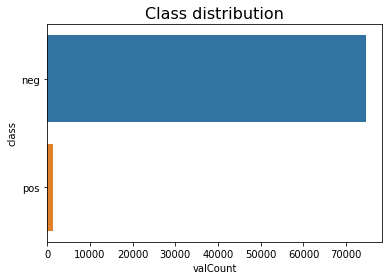

In [8]:
plt.xlabel("Class")
plt.ylabel("Value Count")
plt.title("Class distribution", size=16)
sns.barplot(data=df.groupby("class").size().to_frame("valCount").reset_index(), y="class", x="valCount")
plt.show()

**Примечание**: наблюдается большой дизбаланс

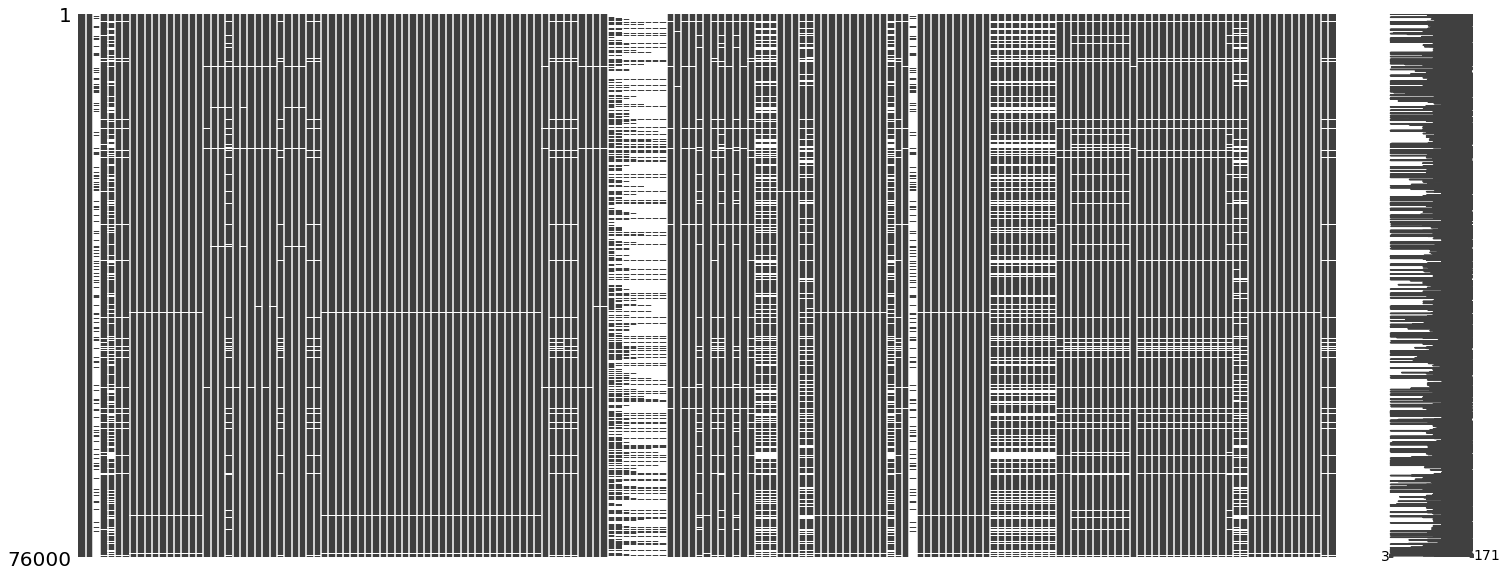

In [12]:
msno.matrix(df)
plt.show()

In [49]:
# Выводим топ 10 признаков с долей пропусков 
missing = (df.isna().sum().sort_values(ascending=False) / df.shape[0]).to_frame("miss").reset_index().head(10)
missing

,index,miss
0,br_000,0.820961
1,bq_000,0.811882
2,bp_000,0.795539
3,bo_000,0.772487
4,cr_000,0.772263
5,ab_000,0.772263
6,bn_000,0.733184
7,bm_000,0.659145
8,bl_000,0.453987
9,bk_000,0.383263


# Моделирование №1 (базовая)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [30]:
def quality_report(pred, truth):
    """
    функция печает метрики качества классификатора
    imput: series: prediction values and actual values
    output: float: accuracy_score, precision_score, recall_score, f1_score
    """
    print("accuracy: {:.4f}; \nprecision: {:.4f}; \nrecall: {:.4f}, \nf1: {:.4f}"\
          .format(accuracy_score(pred, truth), \
                  precision_score(pred, truth, pos_label='pos'), \
                  recall_score(pred, truth, pos_label='pos'), \
                  f1_score(pred, truth, pos_label='pos')))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.3)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((53200, 170), (22800, 170), (53200, 1), (22800, 1))

In [33]:
# Шкалируем значения
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
cls = LogisticRegressionCV(solver='lbfgs')

In [35]:
cls.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [36]:
quality_report(cls.predict(X_test_scaled), y_test)

accuracy: 0.9910; 
precision: 0.6496; 
recall: 0.7888, 
f1: 0.7125


# Моделирование №2 (удаление коррелирующих признаков)

In [25]:
# 1. Удаляем коррелирующие между собой признаки. При этом используется функция рассмотренная на уроке

In [37]:
def corr_feature_detect(data, threshold=0.8):
    
    corrmat = data.drop(['class'], axis=1).corr()

    corrmat = corrmat.abs().unstack().sort_values(ascending=False)

    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1]

    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    correlated_feats = []

    for row in corrmat.values:
        f1, f2, corr_value = row

        if not ((f1 in correlated_feats) | (f2 in correlated_feats)):
            f1_feat_len = corrmat[(corrmat.feature1==f1) | (corrmat.feature2==f1)].shape[0]
            f2_feat_len = corrmat[(corrmat.feature1==f2) | (corrmat.feature2==f2)].shape[0]

            if f1_feat_len >= f2_feat_len:
                correlated_feats.append(f1)
            else:
                correlated_feats.append(f2)
    
    return correlated_feats

In [40]:
THRESHOLD = 0.8
highlyCorrelatedFeatures = corr_feature_detect(df, THRESHOLD)
len(highlyCorrelatedFeatures)

59

In [41]:
# 59 признаков сильно между собой коррелируют, для удаления
data = df.drop(highlyCorrelatedFeatures, axis=1)

In [42]:
data.fillna(0, inplace=True)

In [43]:
# Проверяем точность модели 
X_train, X_test, y_train, y_test = train_test_split(data.drop("class", axis=1), data["class"], test_size=0.3)

In [44]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
cls.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [46]:
quality_report(cls.predict(X_test_scaled), y_test)

accuracy: 0.9376; 
precision: 0.9421; 
recall: 0.2255, 
f1: 0.3639


# Моделирование №3 (обработка пропусков в данных)

In [47]:
# Обработка пропуски. Ранее мы заполняли нулями. Но на этот раз мы попробуем выполнить следующие действия:
# 1) Удаляю признаки, где преобладают пропуски (более 50%)
# 2) Остальные пропуски заполняю средним значеним

In [115]:
# Определяем признаки с большим (>50%) количеством пропусков
missing50 = list(missing[missing["miss"]>0.5]["index"].values)
data = df.drop(missing50, axis=1)

In [116]:
X = data.drop("class", axis=1).apply(lambda x: x.fillna(x.mean()),axis=0)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, data["class"], test_size=0.3)

In [118]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [119]:
cls.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [120]:
quality_report(cls.predict(X_test_scaled), y_test)

accuracy: 0.9909; 
precision: 0.6797; 
recall: 0.7831, 
f1: 0.7277


Обработка пропусков улучшила устойчивость (recall) модели и повысиль общую точность (accuracy) модели

# Моделирование №4 (балансировка выборки)

In [103]:
df["class"].value_counts()

neg    74625
pos     1375
Name: class, dtype: int64

In [104]:
classNegCount, classPosCount = df["class"].value_counts()

In [123]:
df_classNeg = df[df["class"]=="neg"]
df_classPos = df[df["class"]=="pos"]

In [124]:
df_classNeg_undersampled = df_classNeg.sample(classPosCount)
data = pd.concat([df_classNeg_undersampled, df_classPos], axis=0)
data["class"].value_counts()

pos    1375
neg    1375
Name: class, dtype: int64

In [127]:
data = data.drop(missing50, axis=1)

In [128]:
X = data.drop("class", axis=1).apply(lambda x: x.fillna(x.mean()),axis=0)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, data["class"], test_size=0.2)

In [130]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [131]:
cls.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [132]:
quality_report(cls.predict(X_test_scaled), y_test)

accuracy: 0.9582; 
precision: 0.9517; 
recall: 0.9684, 
f1: 0.9600


Балансировка значительно повысила качество модели по всем метрикам, кроме accuracy.
Думаю это хороший результат!